A pipeline for processing single-cell RNA-seq data for bladder cancer

This pipeline is based on dataset [GSE146137](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE146137).


In [1]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
data_path = "data/"
check_path = "checkpoints/"

# os.makedirs(check_path)

os.chdir("../")
print(os.getcwd())

/Users/flynnzhang/CMU/Spring24/02620-ML4Scientists/scRNA-seq_ML


# Leiden

In [3]:
# load adata from file
adata = sc.read(check_path + "harmony.h5ad")

adata

AnnData object with n_obs × n_vars = 23873 × 2723
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/var/folders/fs/dzz16rpn4gb232kj3rp5q6sh0000gn/T/ipykernel_71780/3004916495.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden", resolution = 0.1)


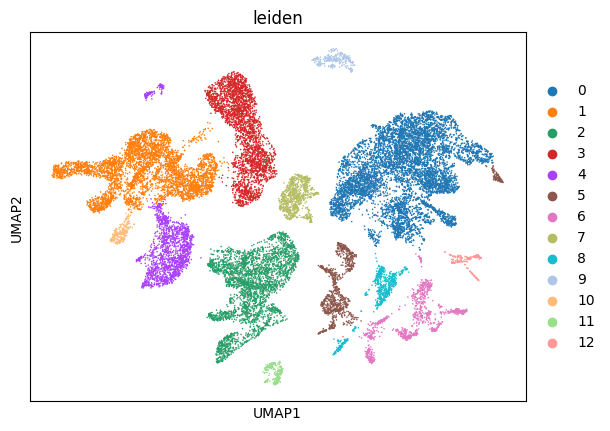

In [4]:
sc.tl.leiden(adata, key_added="leiden", resolution = 0.1)
sc.pl.umap(adata, color = 'leiden')

<Figure size 2000x1000 with 0 Axes>

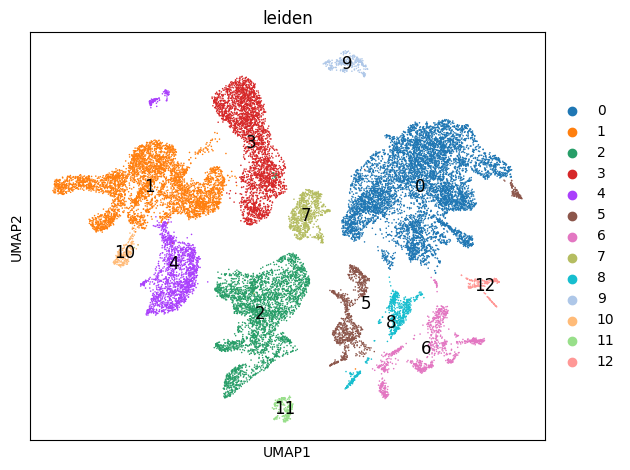

In [5]:
plt.figure(figsize=(20, 10))
ax = sc.pl.umap(adata, color='leiden', show=False)
# Annotate cluster centers
cluster_centers = {}
for cluster in np.unique(adata.obs['leiden']):
    mask = adata.obs['leiden'] == cluster
    center = adata.obsm['X_umap'][mask].mean(axis=0)
    cluster_centers[cluster] = center
    # Use ax.text to add text annotations directly onto the plot
    ax.text(center[0], center[1], str(cluster), fontsize=12, ha='center', va='center', color='black')

# Save the plot with high resolution
plt.tight_layout()
plt.savefig("cluster_with_number.png", dpi=800)
plt.show()

In [6]:
# Plot the UMAP with the expression of potential marker genes colored
# - frameon = False removes the frame around the legend
# - vmax = 5 sets the maximum value of the color scale to 5

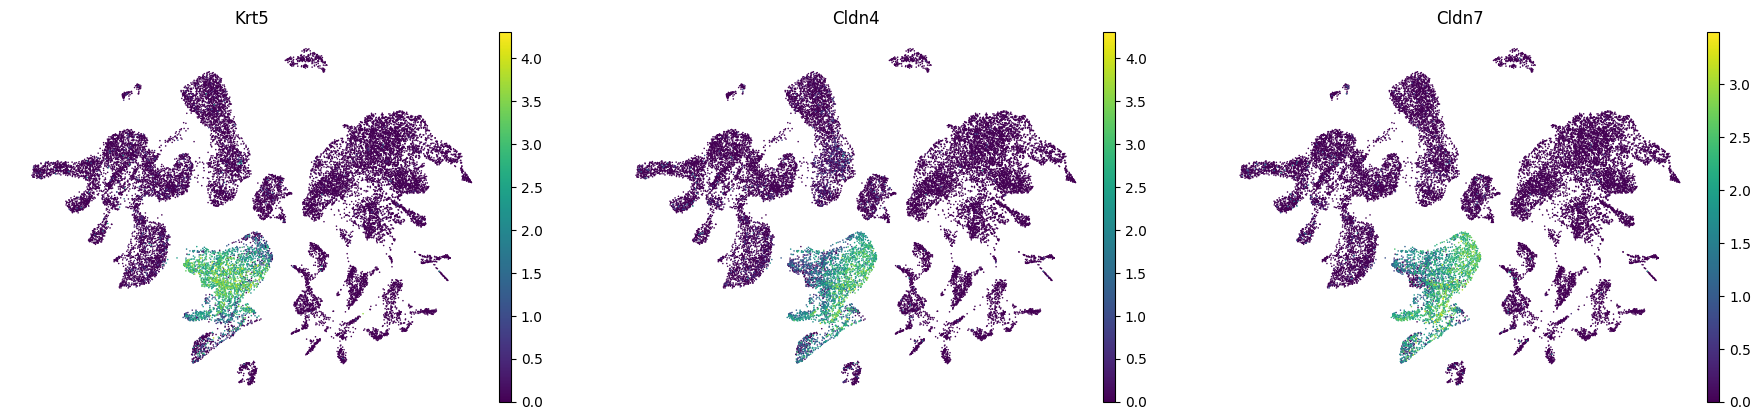

In [7]:
sc.pl.umap(adata, color = ['Krt5', 'Cldn4', 'Cldn7'],
           frameon = False,
          )

In [8]:
marker_genes = {
    # "epithelial cell": ["Trp63", "Cd44", "Itga6", "Cdh1", "Epcam"],
    "stratified epithelia": ["Trp63", "Cd44", "Itga6", "Krt5", "Krt14", "Cdh1", "Epcam"],
    "simple epithelia": ["Trp63", "Cd44", "Itga6", "Krt8", "Cdh1", "Epcam"],
    # "T cells": ["Cd44", "Gata3"],
    "immune cells": ["Cd44", "Gata3", "Axl", "Gas6", "Pdcd1", "Cd274", "Havcr2", "Ptprc"],
    "cancer cells": ["Cd44", "Epcam", "Snai1", "Snai2"],
    "endothelial cells": ["Itga6", "Vim"],
    "fibroblasts": ["Vim", "Acta2", "Fn1"],
    "smoothe muscle cells": ["Acta2"],
}

categories: 0, 1, 2, etc.
var_group_labels: stratified epithelia, simple epithelia, immune cells, etc.


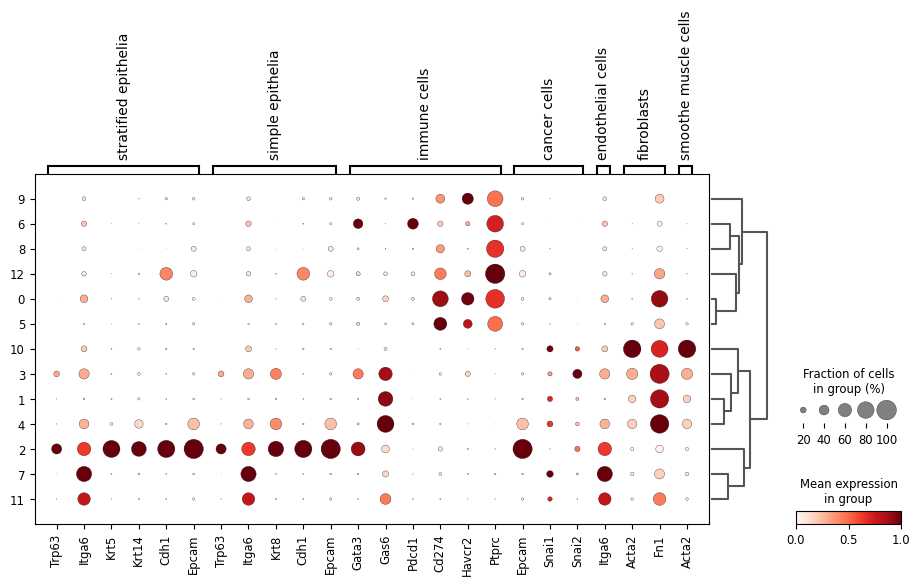

In [9]:
marker_genes_in_data = dict()
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

# Ensure that marker_genes_in_data is not empty and contains valid gene names
if marker_genes_in_data:
    sc.tl.dendrogram(adata, 'leiden', use_rep="X_pca_harmony")
    ax = sc.pl.dotplot(
        adata,
        groupby="leiden",
        var_names=marker_genes_in_data,
        dendrogram=True,
        standard_scale="var",
    )
else:
    print("No marker genes found in the data.")

In [10]:
cluster2annotation = {
     '9': 'immune cells',
     '6': 'immune cells',
     '8': 'immune cells',
     '12': 'immune cells',
     '0': 'immune cells',
     '5': 'immune cells',
     '10': 'smooth muscle cell',
     '3': 'fibroblasts',
     '1': 'fibroblasts',
     '4': 'fibroblasts',
     '2': 'epithelial cells',
     '7': 'endothelial cells', 
     '11': 'endothelial cells', 
}

In [11]:
print(adata.obs.columns)

Index(['Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo',
       'pct_counts_hb', 'batch', 'leiden'],
      dtype='object')


In [12]:
# Map the cluster labels in your AnnData to the cell types
adata.obs['major_celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [13]:
# Save the updated AnnData object if necessary
adata.write_h5ad(check_path + 'cell_type.h5ad')

In [14]:
adata

AnnData object with n_obs × n_vars = 23873 × 2723
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'leiden', 'major_celltype'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

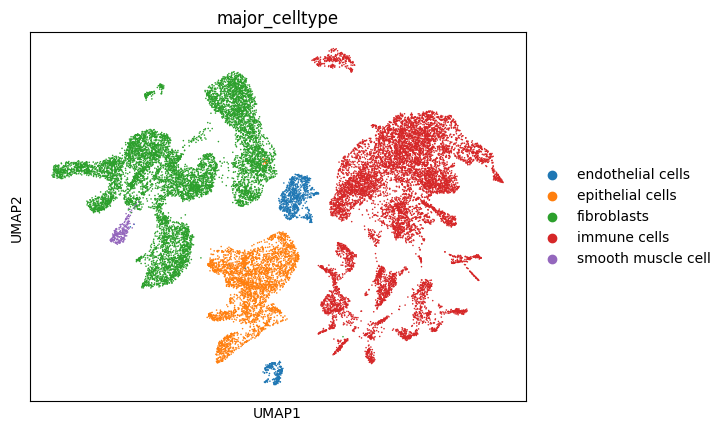

In [15]:
sc.pl.umap(adata, color='major_celltype')